In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
cybersec = pd.read_excel(r".\Global_Cybersecurity_Threats.xlsx")
cybersec.head()

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169.0,Hacker Group,Unpatched Software,VPN,63.0
1,China,2019,Ransomware,Retail,NaN,295961.0,Hacker Group,Unpatched Software,Firewall,71.0
2,India,2017,Man-in-the-Middle,IT,38.65,605895.0,Hacker Group,Weak Passwords,VPN,20.0
3,UK,2024,Ransomware,Telecommunications,41.44,659320.0,Nation-state,Social Engineering,AI-based Detection,7.0
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682.0,NaN,Social Engineering,VPN,68.0


In [11]:
cybersec.dtypes

Country                                 object
Year                                     int64
Attack Type                             object
Target Industry                         object
Financial Loss (in Million $)          float64
Number of Affected Users               float64
Attack Source                           object
Security Vulnerability Type             object
Defense Mechanism Used                  object
Incident Resolution Time (in Hours)    float64
dtype: object

##### Correct data type

In [7]:
cybersec['Year'] = pd.to_datetime(cybersec['Year'], errors='coerce').dt.year
categorical_cols = [
    'Attack Type',
    'Target Industry',
    'Attack Source',
    'Security Vulnerability Type',
    'Defense Mechanism Used'
]
for col in categorical_cols:
    cybersec[col] = cybersec[col].astype('category')

print(cybersec.dtypes)

Country                                  object
Year                                      int32
Attack Type                            category
Target Industry                        category
Financial Loss (in Million $)           float64
Number of Affected Users                float64
Attack Source                          category
Security Vulnerability Type            category
Defense Mechanism Used                 category
Incident Resolution Time (in Hours)     float64
dtype: object


##### Check for NAs

In [13]:
missing = cybersec.isnull().sum()
print(missing)

Country                                  0
Year                                     0
Attack Type                             98
Target Industry                          0
Financial Loss (in Million $)          129
Number of Affected Users               102
Attack Source                           79
Security Vulnerability Type             77
Defense Mechanism Used                   0
Incident Resolution Time (in Hours)     76
dtype: int64


##### Conduct the Little's MCAR test 

In [14]:
from pyampute.exploration.mcar_statistical_tests import MCARTest

ModuleNotFoundError: No module named 'pyampute'

In [15]:
#Select columns with missing values to test
subset = cybersec[['Attack Type',
                   'Financial Loss (in Million $)',
                   'Number of Affected Users',
                   'Security Vulnerability Type',
                   'Attack Source',
                   'Incident Resolution Time (in Hours)']]
# Convert categorical variables to numerical codes
subset_encoded = subset.apply(lambda col: col.astype('category').cat.codes if col.dtypes == 'category' else col)

In [18]:
mt = MCARTest(method="little")
print(mt.little_mcar_test(subset_encoded))

0.8203963075682454


##### The p-value of the test is 0.82, so we can accept the null hypothesis. Which indicates that the missing pattern of the data is Missing Completely At Random. 

##### Because the missingness is unrelated to the data, we can simply drop all the rows with NA values.

In [8]:
cybersec_cleaned = cybersec.dropna()
cybersec_cleaned.isnull().sum()

Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64

##### Check for outliers

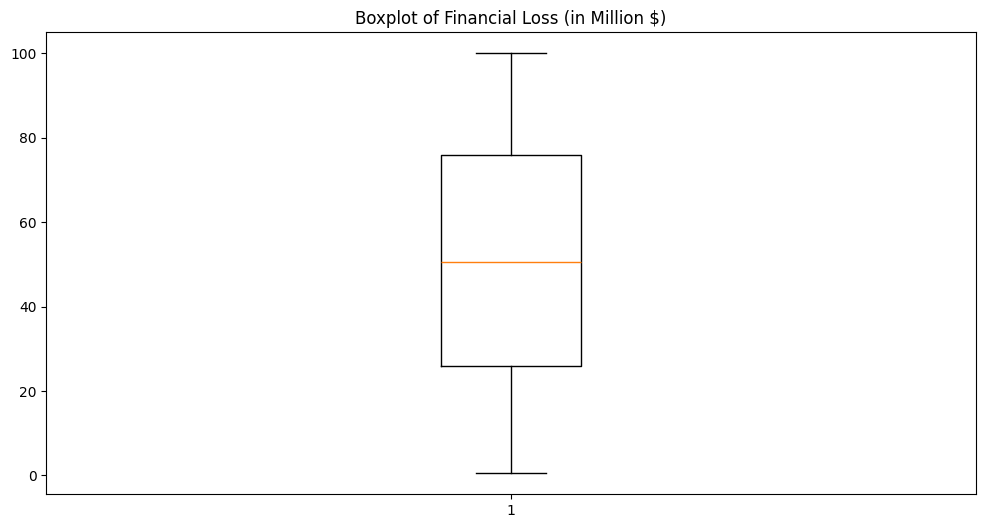

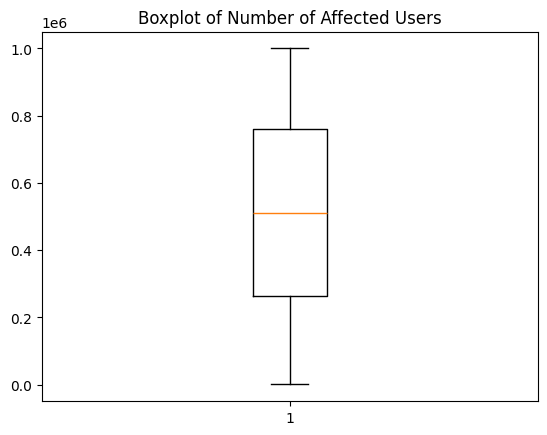

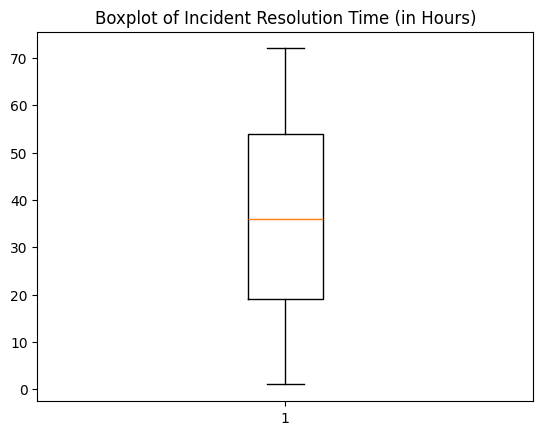

In [9]:
numeric_features = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']
plt.figure(figsize=(12, 6))
for feature in numeric_features:
    plt.boxplot(cybersec_cleaned[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()


TIME SERIES ANALYSIS

Cybersecurity Threats Over the Years

In [45]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

incident_trends = cybersec.groupby('Year', observed=False).size().reset_index(name='Incident Count')

# Tính trend line
x = incident_trends['Year']
y = incident_trends['Incident Count']
coef = np.polyfit(x, y, 1)
trend = np.poly1d(coef)
incident_trends['Trend'] = trend(x)

# Tìm peak
max_idx = incident_trends['Incident Count'].idxmax()
max_year = incident_trends.loc[max_idx, 'Year']
max_value = incident_trends.loc[max_idx, 'Incident Count']

# Vẽ biểu đồ chính
fig = px.line(incident_trends, x='Year', y='Incident Count',
              title='Number of Incidents Over Time',
              labels={'Year': 'Year', 'Incident Count': 'Number of Incidents'},
              markers=True)

# Thêm đường xu hướng
fig.add_trace(go.Scatter(
    x=incident_trends['Year'],
    y=incident_trends['Trend'],
    mode='lines',
    name='Trend Line',
    line=dict(color='orange', dash='dash')
))

# Thêm điểm đỉnh
fig.add_trace(go.Scatter(
    x=[max_year],
    y=[max_value],
    mode='markers+text',
    name='Peak',
    marker=dict(color='red', size=10),
    text=[f"Peak: {max_value}"],
    textposition='top center'
))

fig.update_layout(title_x=0.5, xaxis=dict(tickmode='linear'), width=800, height=400)
fig.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


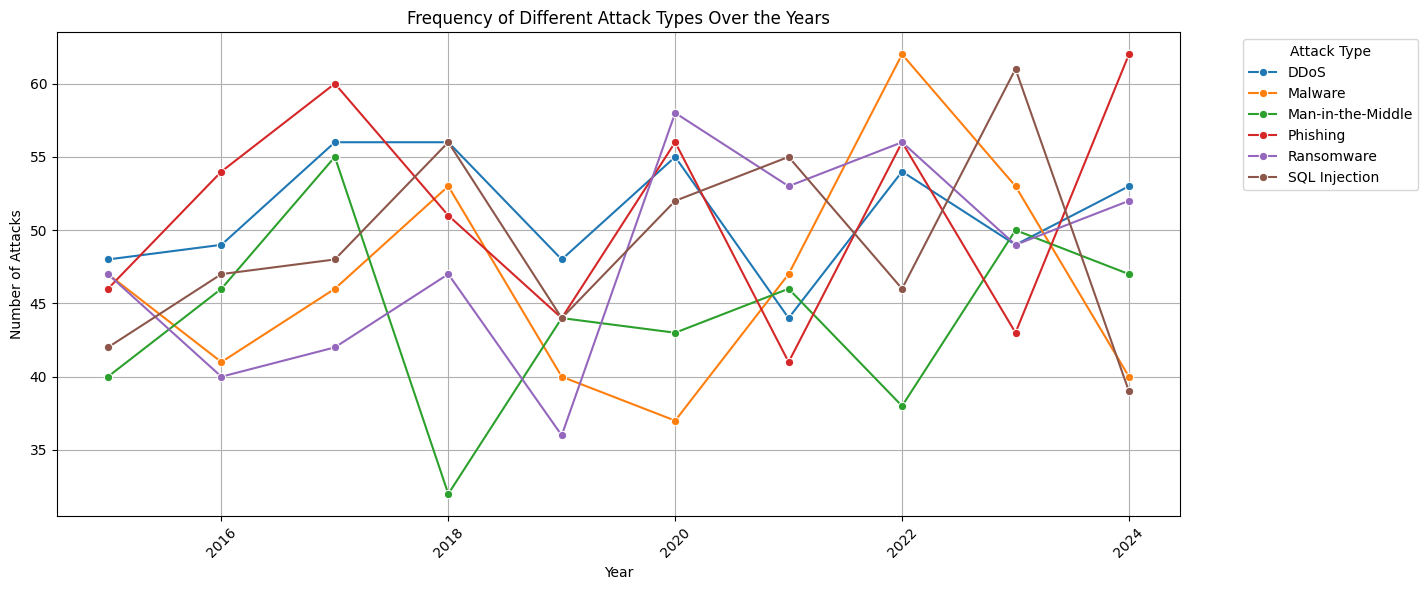

In [4]:
import openpyxl as px
#  Load the Excel file
file_path = "C:/Users/IEC/Downloads/Global_Cybersecurity_Threats.xlsx"
excel_file = pd.ExcelFile(file_path)
# Parse the specific sheet
df = excel_file.parse('Sheet1')

# Group by Year and Attack Type, then count occurrences
attack_counts = df.groupby(['Year', 'Attack Type']).size().reset_index(name='Count')

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=attack_counts, x='Year', y='Count', hue='Attack Type', marker='o')

plt.title('Frequency of Different Attack Types Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

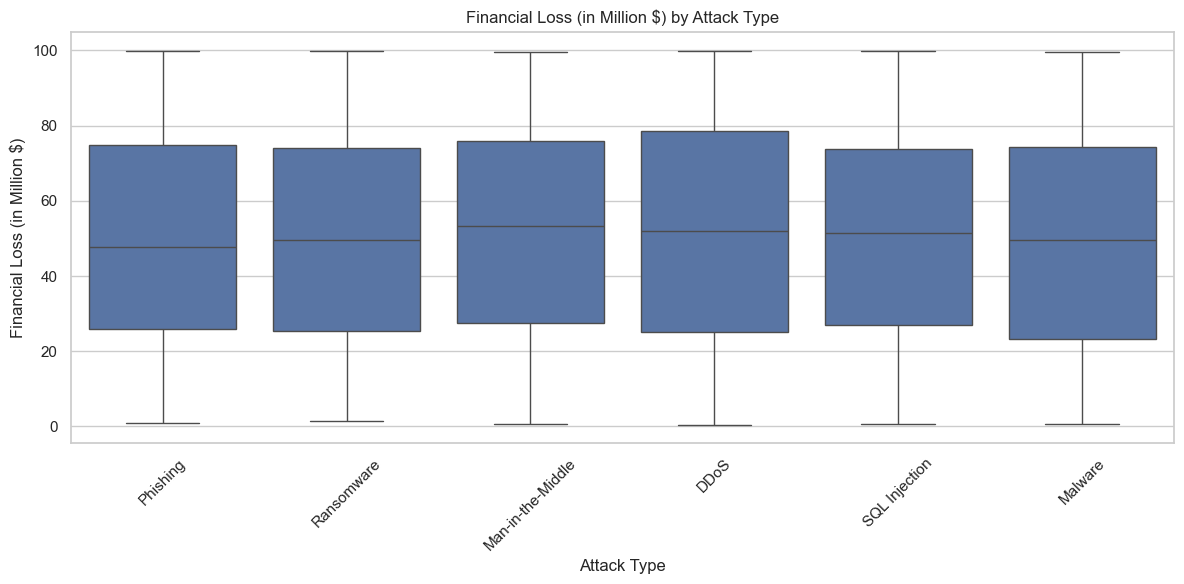

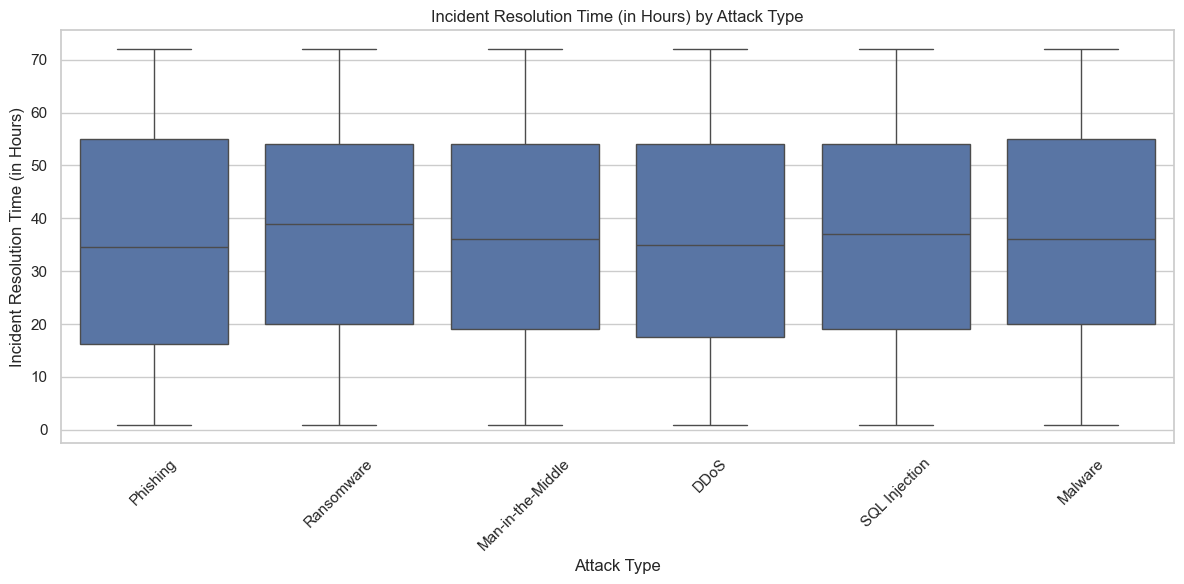

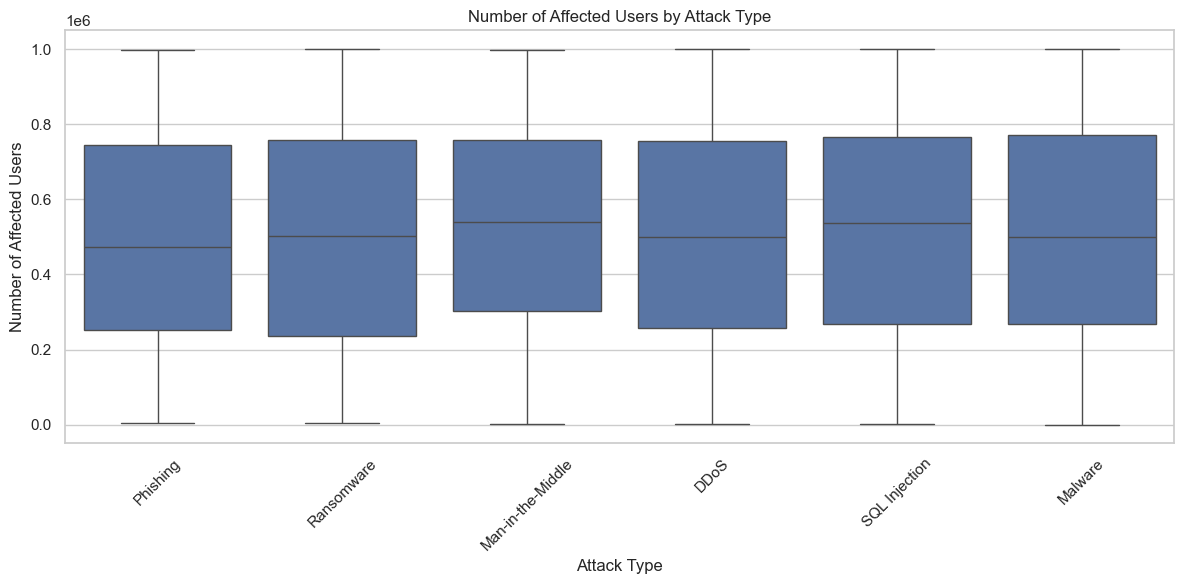

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Excel file
file_path = "C:/Users/IEC/Downloads/Global_Cybersecurity_Threats.xlsx"
excel_file = pd.ExcelFile(file_path)
df = excel_file.parse('Sheet1')

# Set plot style
sns.set(style="whitegrid")

# Define metrics to compare
metrics = ['Financial Loss (in Million $)', 'Incident Resolution Time (in Hours)', 'Number of Affected Users']

# Create a boxplot for each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='Attack Type', y=metric)
    plt.xticks(rotation=45)
    plt.title(f'{metric} by Attack Type')
    plt.tight_layout()
    plt.show()

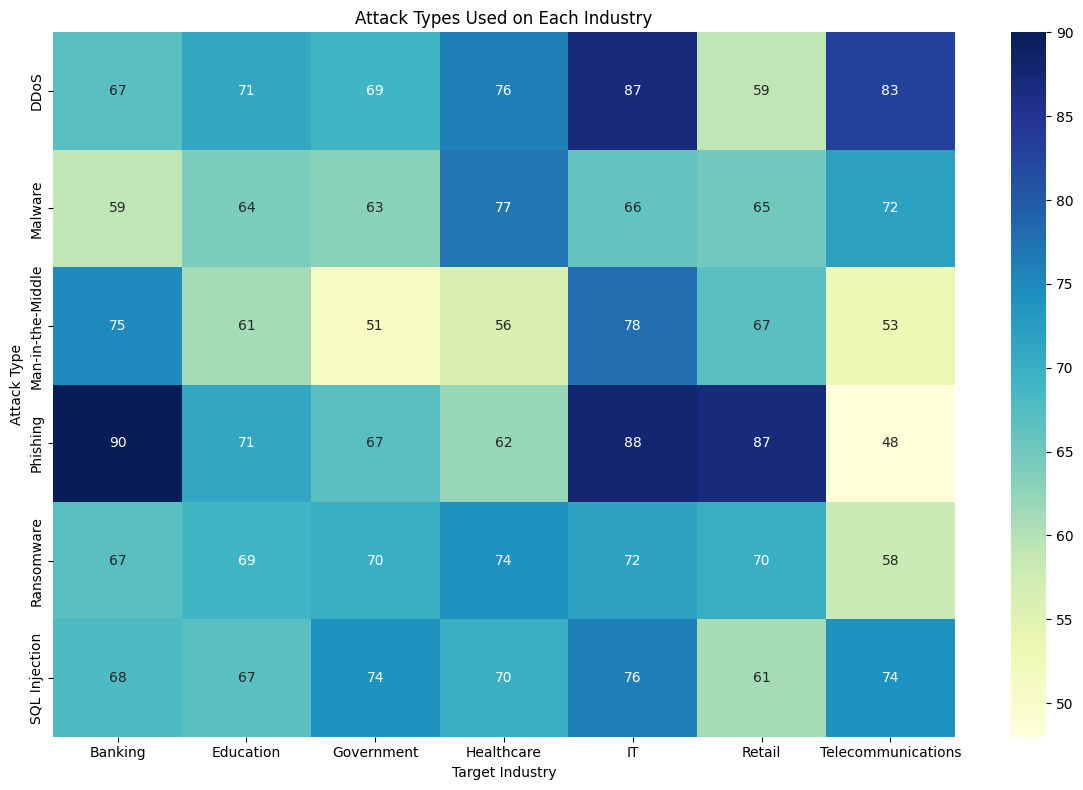

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Load the Excel file
file_path = "C:/Users/IEC/Downloads/Global_Cybersecurity_Threats.xlsx" 
excel_file = pd.ExcelFile(file_path)
df = excel_file.parse('Sheet1')

# Group by Attack Type and Target Industry, then count occurrences
industry_attack_counts = df.groupby(['Attack Type', 'Target Industry']).size().unstack(fill_value=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(industry_attack_counts, annot=True, fmt='d', cmap='YlGnBu')

plt.title('Attack Types Used on Each Industry')
plt.xlabel('Target Industry')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
cybersec_cleaned.head()

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,1970,Phishing,Education,80.53,773169.0,Hacker Group,Unpatched Software,VPN,63.0
2,India,1970,Man-in-the-Middle,IT,38.65,605895.0,Hacker Group,Weak Passwords,VPN,20.0
3,UK,1970,Ransomware,Telecommunications,41.44,659320.0,Nation-state,Social Engineering,AI-based Detection,7.0
5,Germany,1970,Man-in-the-Middle,Retail,98.24,285201.0,Unknown,Social Engineering,Antivirus,25.0
6,Germany,1970,DDoS,Telecommunications,33.26,431262.0,Insider,Unpatched Software,VPN,34.0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11488\1915603020.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = heatmap_df.groupby("Defense Mechanism Used")["Incident Resolution Time (in Hours)"].mean().reset_index()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11488\1915603020.py:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = grouped.pivot_table(index="Defense Mechanism Used", values="Incident Resolution Time (in Hours)")


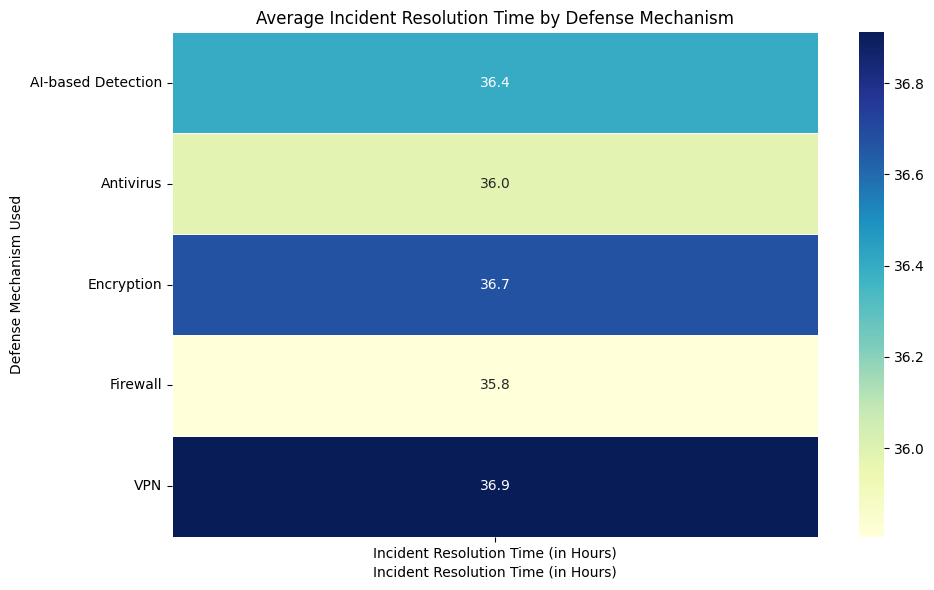

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
cybersec_cleaned.head()

# Lọc dữ liệu đầy đủ
heatmap_df = cybersec_cleaned.dropna(subset=["Defense Mechanism Used", "Incident Resolution Time (in Hours)"])

# Nhóm và tính trung bình thời gian xử lý theo từng cơ chế phòng thủ
grouped = heatmap_df.groupby("Defense Mechanism Used")["Incident Resolution Time (in Hours)"].mean().reset_index()

# Chuyển thành pivot để dùng heatmap
pivot_df = grouped.pivot_table(index="Defense Mechanism Used", values="Incident Resolution Time (in Hours)")

# Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=0.5)

plt.title("Average Incident Resolution Time by Defense Mechanism")
plt.xlabel("Incident Resolution Time (in Hours)")
plt.ylabel("Defense Mechanism Used")
plt.tight_layout()
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11488\3450512327.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = line_df.groupby(["Country", "Attack Type"]).size().reset_index(name="Attack Count")


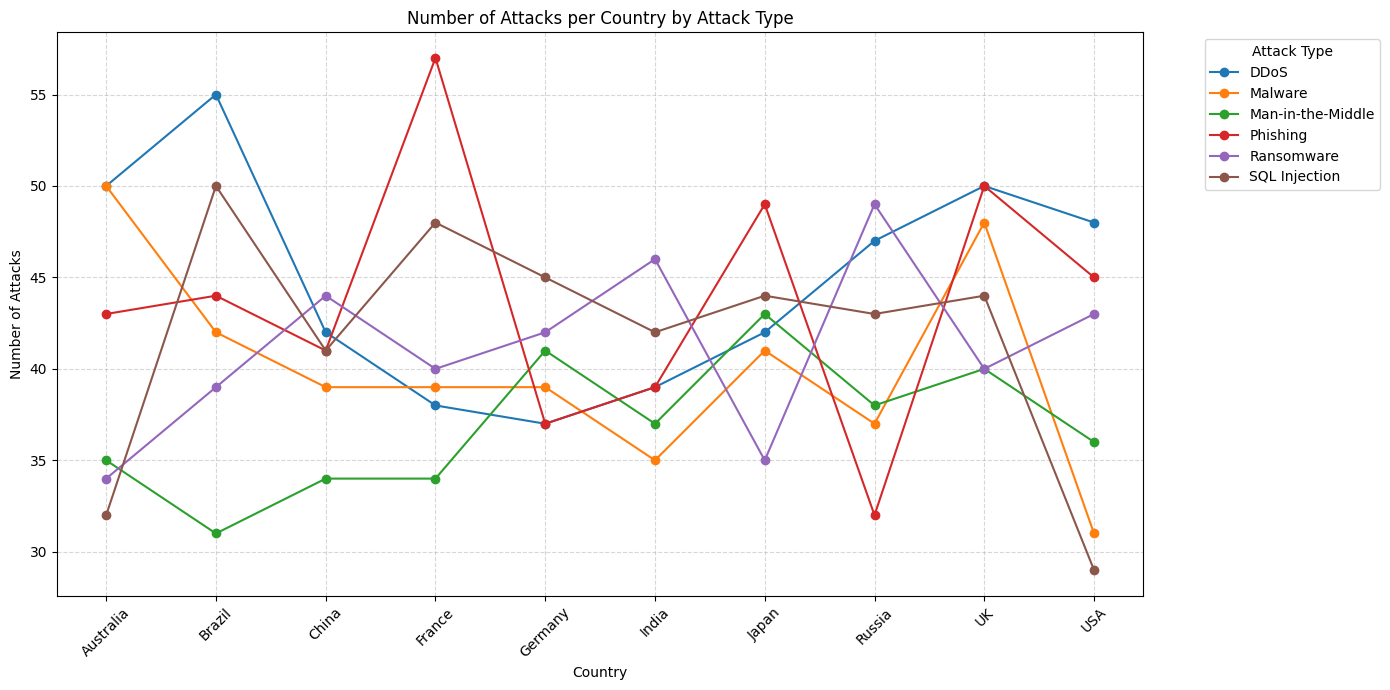

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
cybersec_cleaned.head()

# Nhóm và đếm số vụ tấn công theo từng Country & Attack Type
line_df = cybersec_cleaned.dropna(subset=["Attack Type", "Country"])
grouped = line_df.groupby(["Country", "Attack Type"]).size().reset_index(name="Attack Count")

# Pivot để tạo định dạng phù hợp cho line chart
pivot_df = grouped.pivot(index="Country", columns="Attack Type", values="Attack Count").fillna(0)

# Vẽ biểu đồ line chart
plt.figure(figsize=(14, 7))
for attack_type in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[attack_type], marker='o', label=attack_type)

plt.title("Number of Attacks per Country by Attack Type")
plt.xlabel("Country")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45)
plt.legend(title="Attack Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()